# Importation des bibliothèques et des données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing, decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
dispo_ali = pd.read_csv('P9_DisponibiliteAlimentaire_2017.csv')
pop = pd.read_csv('P9_Population_2000_2018.csv')
economie = pd.read_csv('P9_Economie_Data.csv')
population = pd.read_csv('P9_Population_Data.csv')
Imports_exports = pd.read_csv('P9_Imports-Exports_Data.csv')

# Préparation des données

In [3]:
data_ali = dispo_ali[['Zone', 'Élément', 'Produit', 'Valeur']]
data_ali = data_ali.groupby(['Zone', 'Élément']).sum().reset_index()
data_ali = data_ali.pivot(index='Zone', columns='Élément', values='Valeur').reset_index()

eco = economie.pivot(index='Pays', columns='Serie', values='Valeurs 2017').reset_index()
popu = population.pivot(index='Pays', columns='Serie', values='Valeurs 2017').reset_index()
imp_exp = Imports_exports.pivot(index='Pays', columns='Serie', values='Valeurs 2017').reset_index()

In [4]:
cols_eco = [1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,21,22]
eco_data = eco.drop(eco.columns[cols_eco], axis=1)

cols_pop = [3,6]
pop_data = popu.drop(popu.columns[cols_pop], axis=1)

cols_imp_exp = [1,2,3,4,5,8]
imp_exp_data = imp_exp.drop(imp_exp.columns[cols_imp_exp], axis=1)

data = data_ali.merge(eco_data, left_on='Zone', right_on='Pays').merge(imp_exp_data, on='Pays').merge(pop_data, on='Pays').set_index('Zone')
data.drop(columns='Pays', axis=1, inplace=True)

# ACP

### Déterminer le nombre de composantes

In [5]:
data = data.fillna(data.mean())

X = data.values
names = data.index
n = X.shape[0]
p = X.shape[1]

In [6]:
X_scaled = preprocessing.StandardScaler().fit_transform(X)

pca = decomposition.PCA()
coord = pca.fit_transform(X_scaled)

# Valeur propre
valprop = (n-1)/n*pca.explained_variance_

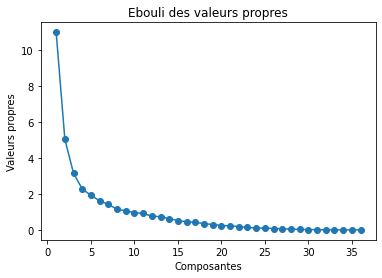

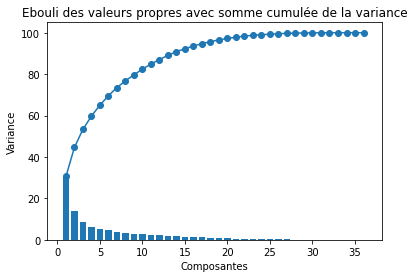

,Val.Propre,Seuils,Var.ratio,Var.sum
0,1.101372e+01,4.174559,30.59,30.593654
1,5.052399e+00,3.174559,14.03,44.628095
2,3.149460e+00,2.674559,8.75,53.376594
3,2.284672e+00,2.341226,6.35,59.722905
4,1.926602e+00,2.091226,5.35,65.074577
5,1.624847e+00,1.891226,4.51,69.588041
6,1.423581e+00,1.724559,3.95,73.542432
7,1.154540e+00,1.581702,3.21,76.749487
8,1.061883e+00,1.456702,2.95,79.699161
9,9.610896e-01,1.345591,2.67,82.368855


In [7]:
# Scree plot
plt.plot(np.arange(1,p+1),valprop, marker='o')
plt.title("Ebouli des valeurs propres")
plt.ylabel("Valeurs propres")
plt.xlabel("Composantes")
plt.savefig("P9_Scree_plot.png", dpi=300)
plt.show()

scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),marker='o')
plt.title("Ebouli des valeurs propres avec somme cumulée de la variance")
plt.ylabel("Variance")
plt.xlabel("Composantes")
plt.savefig("P9_Scree_plot_cumsum.png", dpi=300)
plt.show()

# Seuils pour test des bâtons brisés
bs = 1/np.arange(p,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]
ratio = np.around(100*pca.explained_variance_ratio_, decimals=2)
var_sum = np.cumsum(100*pca.explained_variance_ratio_)

all_values = pd.DataFrame({'Val.Propre':valprop,'Seuils':bs, 'Var.ratio':ratio, 'Var.sum':var_sum})
all_values.to_csv("P9_test_baton_brisé.csv")
display(all_values)

### Représentation des individus sur les 2 premiers plans factoriels

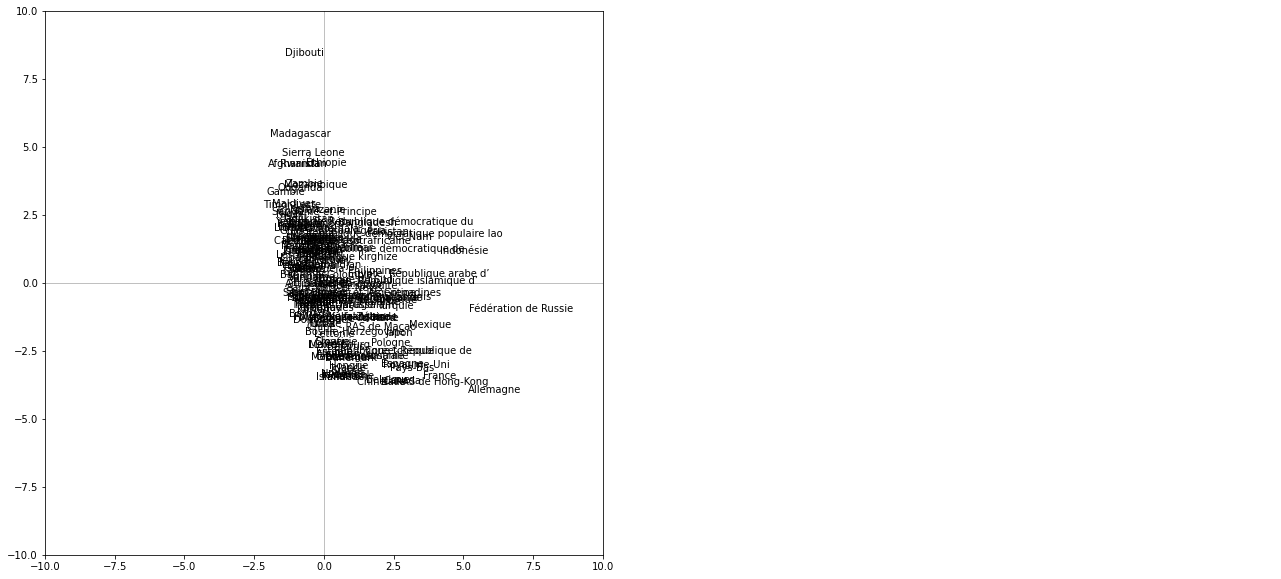

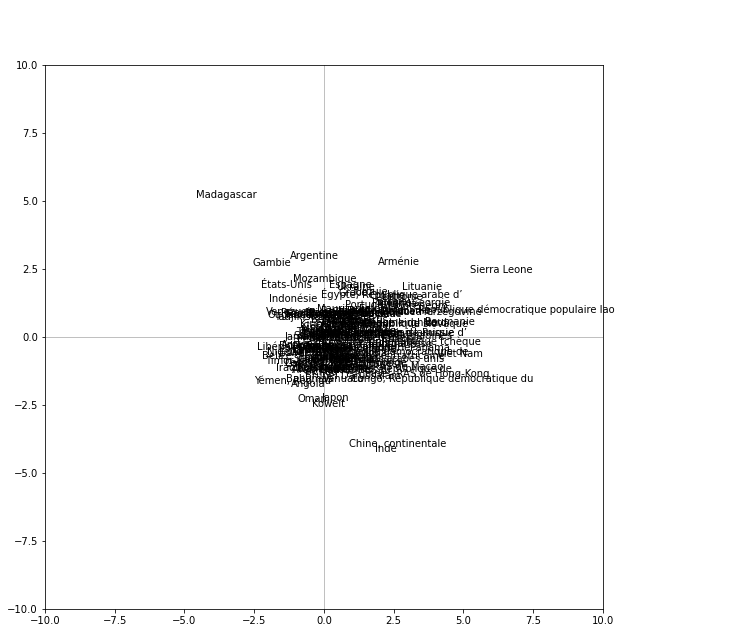

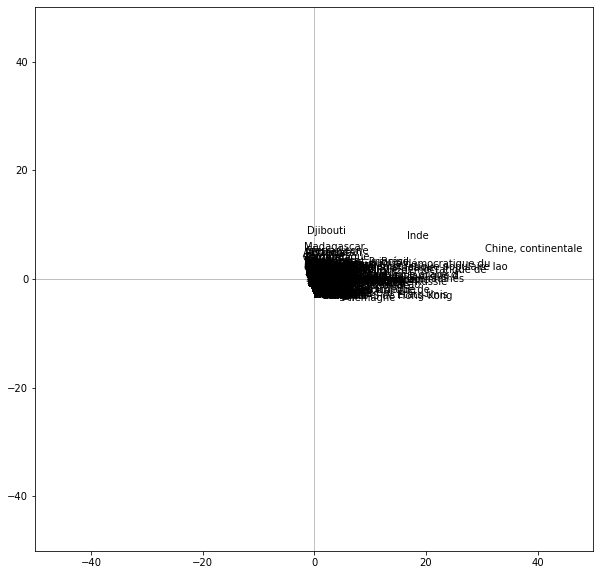

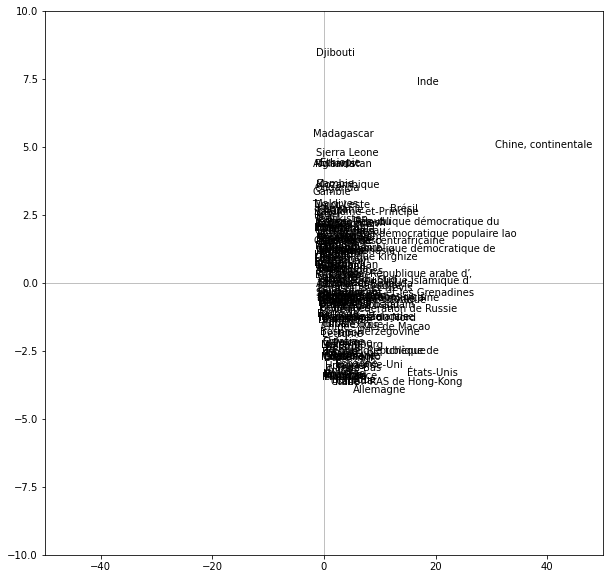

In [8]:
def rep_ind(size, names, n, coord, comp, savename):
    fig, axes = plt.subplots(figsize=(10,10))
    axes.set_xlim(size)
    axes.set_ylim(size)
    for i in range(n):
        plt.annotate(names[i],(coord[i,comp[0]],coord[i,comp[1]]))
    plt.plot(size,[0,0],color='silver',linestyle='-',linewidth=1)
    plt.plot([0,0],size,color='silver',linestyle='-',linewidth=1)
    plt.savefig(savename,dpi=300)
    plt.show()

#2 premiers plans, même axes
rep_ind([-10,10], names, n, coord, [0,1], "P9_rep_ind_1.png")
rep_ind([-10,10], names, n, coord, [2,3], "P9_rep_ind_2.png")

#1er plan, même axes
rep_ind([-50,50], names, n, coord, [0,1], "P9_rep_ind_3.png")

#1er plan, axes ajustés
fig, axes = plt.subplots(figsize=(10,10))
axes.set_xlim(-50,50)
axes.set_ylim(-10,10)
for i in range(n):
    plt.annotate(names[i],(coord[i,0],coord[i,1]))
plt.plot([-50,50],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-10,10],color='silver',linestyle='-',linewidth=1)
plt.show()

In [9]:
#contributions des individus aux axes
ctr = coord**2
for j in range(p):
    ctr[:,j] = ctr[:,j]/(n*valprop[j])

crt_ind_df = pd.DataFrame({'id':names,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1],'CTR_3':ctr[:,2],'CTR_4':ctr[:,3],
                           'CTR_5':ctr[:,4],'CTR_6':ctr[:,5],'CTR_7':ctr[:,6],'CTR_8':ctr[:,7],'CTR_9':ctr[:,8]})
display(crt_ind_df)


#corrélation des variables avec les axes
sqrt_valprop = np.sqrt(valprop)

corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = pca.components_[k,:]*sqrt_valprop[k]

cor_var_df = pd.DataFrame({'id':data.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1],'COR_3':corvar[:,2],'COR_4':corvar[:,3],
                          'COR_5':corvar[:,4],'COR_6':corvar[:,5],'COR_7':corvar[:,6],'COR_8':corvar[:,7],'COR_9':corvar[:,8]})
display(cor_var_df)

,id,CTR_1,CTR_2,CTR_3,CTR_4,CTR_5,CTR_6,CTR_7,CTR_8,CTR_9
0,Afghanistan,0.002093,2.072558e-02,0.001640,0.000037,0.000247,0.012138,0.002616,0.001108,0.005157
1,Afrique du Sud,0.000016,1.940877e-07,0.000009,0.001407,0.009451,0.014348,0.025096,0.006067,0.000416
2,Albanie,0.000045,8.424564e-03,0.011394,0.001768,0.000149,0.002790,0.000687,0.005241,0.005719
3,Algérie,0.000080,1.604819e-05,0.000493,0.002367,0.014966,0.012884,0.008504,0.008899,0.000044
4,Allemagne,0.013912,1.862979e-02,0.000037,0.000335,0.009144,0.000057,0.006277,0.004759,0.051979
...,...,...,...,...,...,...,...,...,...,...
168,Émirats arabes unis,0.000043,4.703561e-04,0.001003,0.002122,0.008411,0.042731,0.001566,0.017533,0.000595
169,Équateur,0.000418,1.033818e-03,0.000926,0.001796,0.001048,0.008265,0.001317,0.001026,0.001424
170,États-Unis,0.116092,1.332430e-02,0.009200,0.008217,0.062447,0.000234,0.144558,0.004867,0.000143
171,Éthiopie,0.000222,2.124482e-02,0.008054,0.000084,0.004754,0.011620,0.008145,0.003448,0.003798


,id,COR_1,COR_2,COR_3,COR_4,COR_5,COR_6,COR_7,COR_8,COR_9
0,Alimentation pour touristes,-0.084342,0.003315,-0.083780,0.081796,-0.229215,-0.343217,-0.177721,-0.338864,0.284078
1,Aliments pour animaux,0.916322,0.103706,-0.036510,-0.050240,0.061130,-0.108205,-0.107443,0.001653,-0.149658
2,Autres utilisations (non alimentaire),0.626151,0.076796,-0.308010,0.489356,0.211522,0.042671,-0.204179,0.021791,0.209257
3,Disponibilité alimentaire (Kcal/personne/jour),0.320146,-0.770508,0.238121,0.192010,0.085623,-0.002353,0.107277,-0.309556,0.009046
4,Disponibilité alimentaire en quantité (kg/pers...,0.285826,-0.739579,0.256004,0.233393,-0.053452,-0.050787,0.123631,-0.190519,0.041509
5,Disponibilité de matière grasse en quantité (g...,0.256384,-0.812361,0.114696,0.170086,0.075710,-0.049288,-0.019510,-0.173170,0.083685
6,Disponibilité de protéines en quantité (g/pers...,0.287157,-0.767963,0.239934,0.139007,0.092489,0.045232,0.117825,-0.268147,-0.001392
7,Disponibilité intérieure,0.963604,0.201794,-0.091935,0.011152,-0.015375,-0.053991,-0.005044,-0.008402,0.036341
8,Exportations - Quantité,0.639958,-0.201891,-0.186934,0.379422,0.223138,0.097088,-0.170533,0.080512,0.072932
9,Importations - Quantité,0.867567,-0.075436,0.007253,-0.132556,0.141263,-0.094384,-0.071628,-0.008675,-0.351621


### Cercles de corrélations des variables sur les 2 premiers plans factoriels

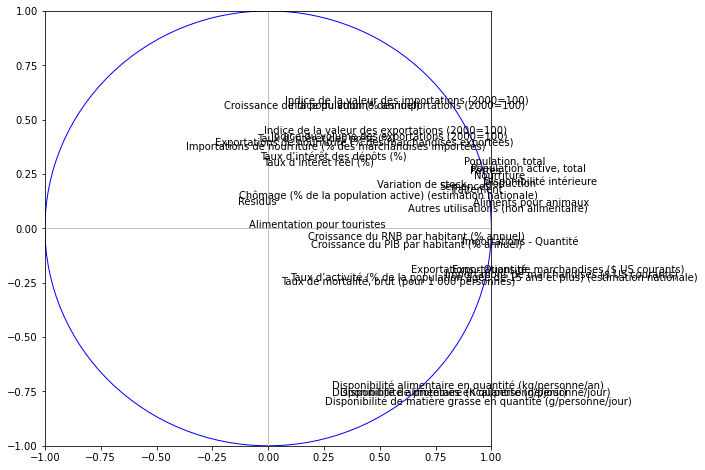

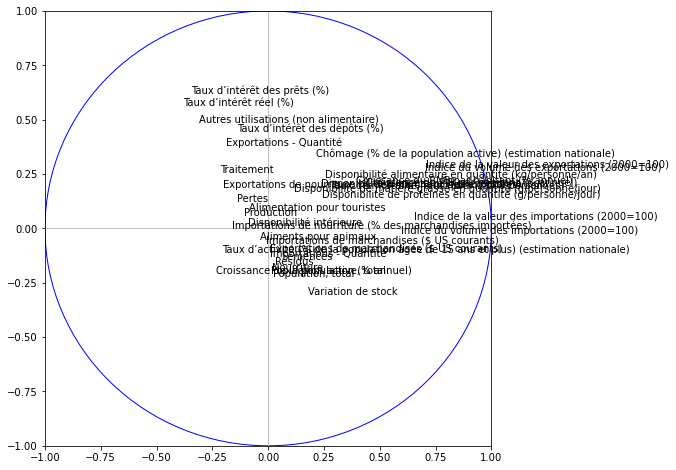

In [10]:
def cercle_corr(df, shape, var, corvar, savename):
    fig, axes = plt.subplots(figsize=(8,8))
    axes.set_xlim(-1,1)
    axes.set_ylim(-1,1)
    for i in range(shape):
        plt.annotate(df.columns[i],(corvar[i,var[0]],corvar[i,var[1]]))
    plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
    plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)
    cercle = plt.Circle((0,0),1,color='blue',fill=False)
    axes.add_artist(cercle)
    plt.savefig(savename,dpi=300)
    plt.show()
    
cercle_corr(data, p, (0,1), corvar, "P9_cercle_corr_1.png")
cercle_corr(data, p, (2,3), corvar, "P9_cercle_corr_2.png")

In [11]:
#cosinus carré des variables
cos2var = np.around(corvar**2, decimals=5)
cos_var_df = pd.DataFrame({'id':data.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1],'COS2_3':cos2var[:,2],
                           'COS2_4':cos2var[:,3],'COS2_5':cos2var[:,4],'COS2_6':cos2var[:,5],
                           'COS2_7':cos2var[:,6],'COS2_8':cos2var[:,7],'COS2_9':cos2var[:,8]})
display(cos_var_df)

#contributions des variables aux axes
ctrvar = cos2var
for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/valprop[k]

ctr_var_df = pd.DataFrame({'id':data.columns,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1],'CTR_3':ctrvar[:,2],
                           'CTR_4':ctrvar[:,3],'CTR_5':ctrvar[:,4],'CTR_6':ctrvar[:,5],
                           'CTR_7':ctrvar[:,6],'CTR_8':ctrvar[:,7],'CTR_9':ctrvar[:,8]})

display(ctr_var_df)

,id,COS2_1,COS2_2,COS2_3,COS2_4,COS2_5,COS2_6,COS2_7,COS2_8,COS2_9
0,Alimentation pour touristes,0.00711,0.00001,0.00702,0.00669,0.05254,0.11780,0.03158,0.11483,0.08070
1,Aliments pour animaux,0.83965,0.01076,0.00133,0.00252,0.00374,0.01171,0.01154,0.00000,0.02240
2,Autres utilisations (non alimentaire),0.39207,0.00590,0.09487,0.23947,0.04474,0.00182,0.04169,0.00047,0.04379
3,Disponibilité alimentaire (Kcal/personne/jour),0.10249,0.59368,0.05670,0.03687,0.00733,0.00001,0.01151,0.09582,0.00008
4,Disponibilité alimentaire en quantité (kg/pers...,0.08170,0.54698,0.06554,0.05447,0.00286,0.00258,0.01528,0.03630,0.00172
5,Disponibilité de matière grasse en quantité (g...,0.06573,0.65993,0.01316,0.02893,0.00573,0.00243,0.00038,0.02999,0.00700
6,Disponibilité de protéines en quantité (g/pers...,0.08246,0.58977,0.05757,0.01932,0.00855,0.00205,0.01388,0.07190,0.00000
7,Disponibilité intérieure,0.92853,0.04072,0.00845,0.00012,0.00024,0.00292,0.00003,0.00007,0.00132
8,Exportations - Quantité,0.40955,0.04076,0.03494,0.14396,0.04979,0.00943,0.02908,0.00648,0.00532
9,Importations - Quantité,0.75267,0.00569,0.00005,0.01757,0.01996,0.00891,0.00513,0.00008,0.12364


,id,CTR_1,CTR_2,CTR_3,CTR_4,CTR_5,CTR_6,CTR_7,CTR_8,CTR_9
0,Alimentation pour touristes,0.000646,0.000002,0.002229,0.002928,0.027271,0.072499,0.022183,0.099460,0.075997
1,Aliments pour animaux,0.076237,0.002130,0.000422,0.001103,0.001941,0.007207,0.008106,0.000000,0.021095
2,Autres utilisations (non alimentaire),0.035598,0.001168,0.030123,0.104816,0.023222,0.001120,0.029285,0.000407,0.041238
3,Disponibilité alimentaire (Kcal/personne/jour),0.009306,0.117505,0.018003,0.016138,0.003805,0.000006,0.008085,0.082994,0.000075
4,Disponibilité alimentaire en quantité (kg/pers...,0.007418,0.108261,0.020810,0.023841,0.001484,0.001588,0.010733,0.031441,0.001620
5,Disponibilité de matière grasse en quantité (g...,0.005968,0.130617,0.004178,0.012663,0.002974,0.001496,0.000267,0.025976,0.006592
6,Disponibilité de protéines en quantité (g/pers...,0.007487,0.116731,0.018279,0.008456,0.004438,0.001262,0.009750,0.062276,0.000000
7,Disponibilité intérieure,0.084307,0.008060,0.002683,0.000053,0.000125,0.001797,0.000021,0.000061,0.001243
8,Exportations - Quantité,0.037185,0.008067,0.011094,0.063011,0.025843,0.005804,0.020427,0.005613,0.005010
9,Importations - Quantité,0.068339,0.001126,0.000016,0.007690,0.010360,0.005484,0.003604,0.000069,0.116435


### ACP finale

In [12]:
n_comp = 9

acp = decomposition.PCA(n_components=n_comp)

X_project = acp.fit_transform(X_scaled)
ACP = pd.DataFrame(X_project, index=data.index)

In [13]:
ACP_names = ACP.rename(columns={0:"Forte population et dispo ali", 1:"Croissance population et imports/exports", 
                                    2:"Croissance imports/exports et PIB/RNB", 3:"Chômage et fortes exportations", 
                                    4:"Peu de croissance PIB/RNB par rapport croissance pop et commerce extérieur", 5:"Croissance emploi", 
                                    6:"Limitation commerce extérieur", 7:"Augmentation taux de mortalité", 
                                    8:"Augmentation emploi, tourisme, limitation imports"})
ACP_names

,Forte population et dispo ali,Croissance population et imports/exports,Croissance imports/exports et PIB/RNB,Chômage et fortes exportations,Peu de croissance PIB/RNB par rapport croissance pop et commerce extérieur,Croissance emploi,Limitation commerce extérieur,Augmentation taux de mortalité,"Augmentation emploi, tourisme, limitation imports"
Zone,,,,,,,,,
Afghanistan,-1.996777,4.256231,-0.945179,-0.121441,-0.287040,-1.847117,-0.802703,-0.470371,-0.973294
Afrique du Sud,-0.175849,0.013025,-0.069024,0.745761,1.774836,-2.008316,2.486064,1.100794,0.276296
Albanie,-0.293877,-2.713598,2.491602,0.835937,0.222678,-0.885559,0.411245,-1.023172,1.024968
Algérie,-0.390696,-0.118436,0.518268,-0.967315,2.233408,-1.903099,1.447177,-1.333188,-0.090274
Allemagne,5.148598,-4.035300,-0.141488,0.363920,1.745813,0.126664,-1.243298,0.974952,-3.090113
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,0.284856,-0.641188,0.739238,-0.915725,1.674299,3.465794,-0.621005,-1.871371,0.330710
Équateur,-0.892280,0.950592,-0.710120,-0.842540,0.591031,1.524200,-0.569505,-0.452731,0.511393
États-Unis,14.872725,-3.412668,-2.238945,1.802143,4.562201,-0.256466,-5.966705,0.985957,-0.162059


# CAH

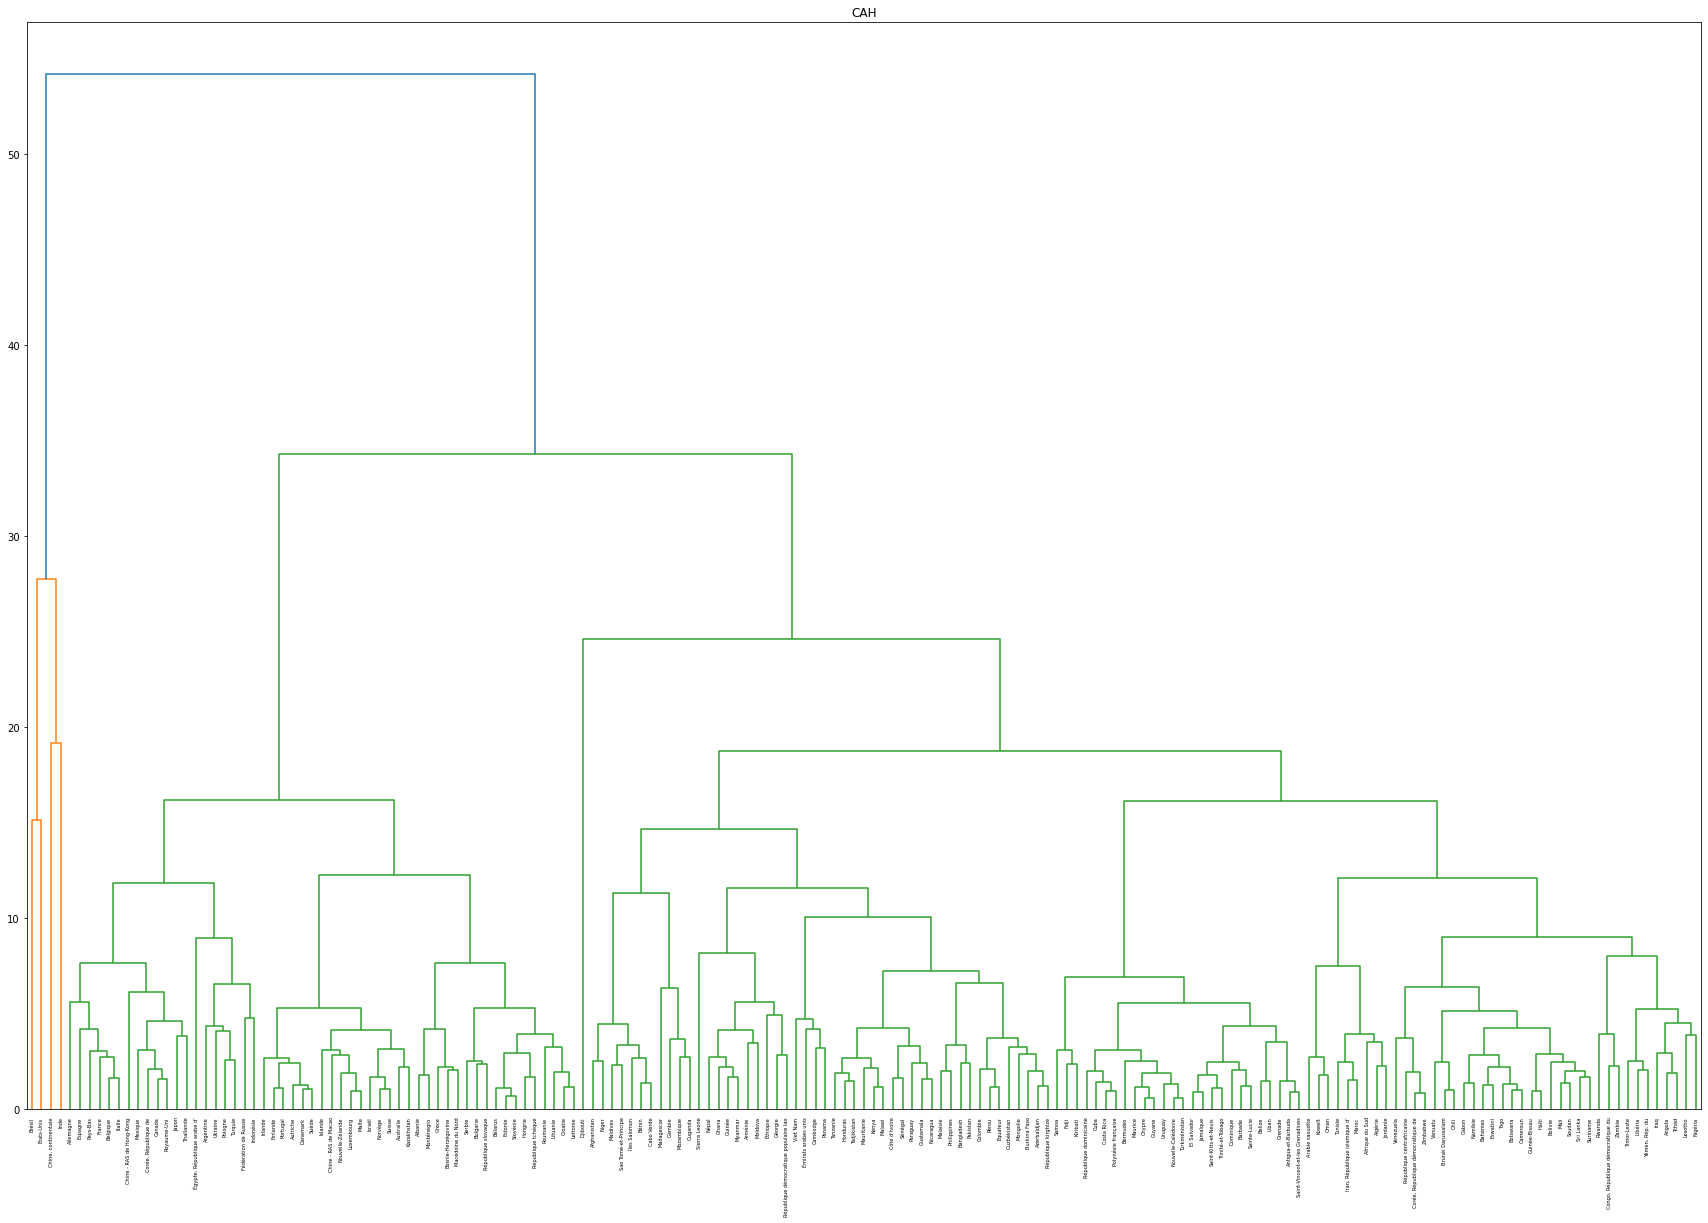

In [14]:
Z = linkage(X_project, 'ward')

plt.figure(figsize=(30,20))
plt.title("CAH")
dendrogram(Z, labels=names, orientation='top')
plt.savefig("P9_Class_Asc_Hier.png", dpi=300)
plt.show()

# Clustering K-means

### Déterminer le nombre de clusters

In [15]:
clusters= []
inertia = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k, random_state=10)
    km = km.fit(X_project)
    clusters.append(km)
    inertia.append(km.inertia_)

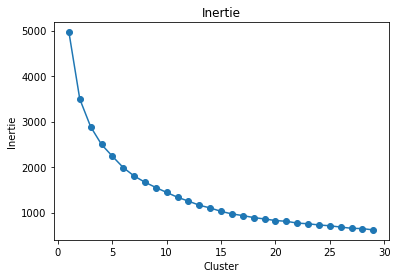

In [16]:
# Méthode du coude
plt.plot(K, inertia, marker='o')
plt.title("Inertie")
plt.xlabel('Cluster')
plt.ylabel('Inertie')
plt.savefig("P9_kmeans_elbow.png")
plt.show()

In [17]:
# Coefficient de silhouette
for i in range(3,15,1):
    
    print("---------------------------------------")
    print(clusters[i])
    print("Silhouette score:",silhouette_score(ACP, clusters[i].predict(ACP)))

---------------------------------------
KMeans(n_clusters=4, random_state=10)
Silhouette score: 0.23268079644793743
---------------------------------------
KMeans(n_clusters=5, random_state=10)
Silhouette score: 0.23174420571157164
---------------------------------------
KMeans(n_clusters=6, random_state=10)
Silhouette score: 0.16048119098730507
---------------------------------------
KMeans(n_clusters=7, random_state=10)
Silhouette score: 0.14771632980497912
---------------------------------------
KMeans(random_state=10)
Silhouette score: 0.14791746988203508
---------------------------------------
KMeans(n_clusters=9, random_state=10)
Silhouette score: 0.1443332436924277
---------------------------------------
KMeans(n_clusters=10, random_state=10)
Silhouette score: 0.15606305205020127
---------------------------------------
KMeans(n_clusters=11, random_state=10)
Silhouette score: 0.1394570505849415
---------------------------------------
KMeans(n_clusters=12, random_state=10)
Silhoue

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


,Scaled Inertia
k,
2,0.782245
3,0.640752
4,0.583032
5,0.554158
6,0.520418
7,0.503160
8,0.497587
9,0.489635
10,0.487070


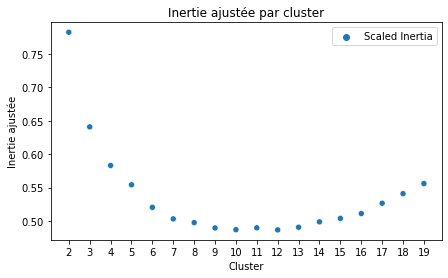

In [18]:
# Inertie ajustée

from joblib import Parallel, delayed

def kMeansRes(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeansParallel(scaled_data, k_range):
    ans = Parallel(n_jobs=-1,verbose=10)(delayed(kMeansRes)(scaled_data, k) for k in k_range)
    ans = list(zip(k_range,ans))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

k_range=range(2,20)
# compute adjusted intertia
best_k, results = chooseBestKforKMeansParallel(X_project, k_range)

display(results)
plt.figure(figsize=(7,4))
sns.scatterplot(data=results)
plt.title('Inertie ajustée par cluster')
plt.xlabel('Clusters')
plt.ylabel('Inertie ajustée')
plt.xticks(range(2,20,1))
plt.savefig("P9_Kmeans_adjusted_inertia.png",dpi=300)
plt.show()

### Réalisation du clustering

In [19]:
n_clust = 12

km = KMeans(n_clusters=n_clust, random_state=10)
km.fit(X_project)

clusters = km.labels_

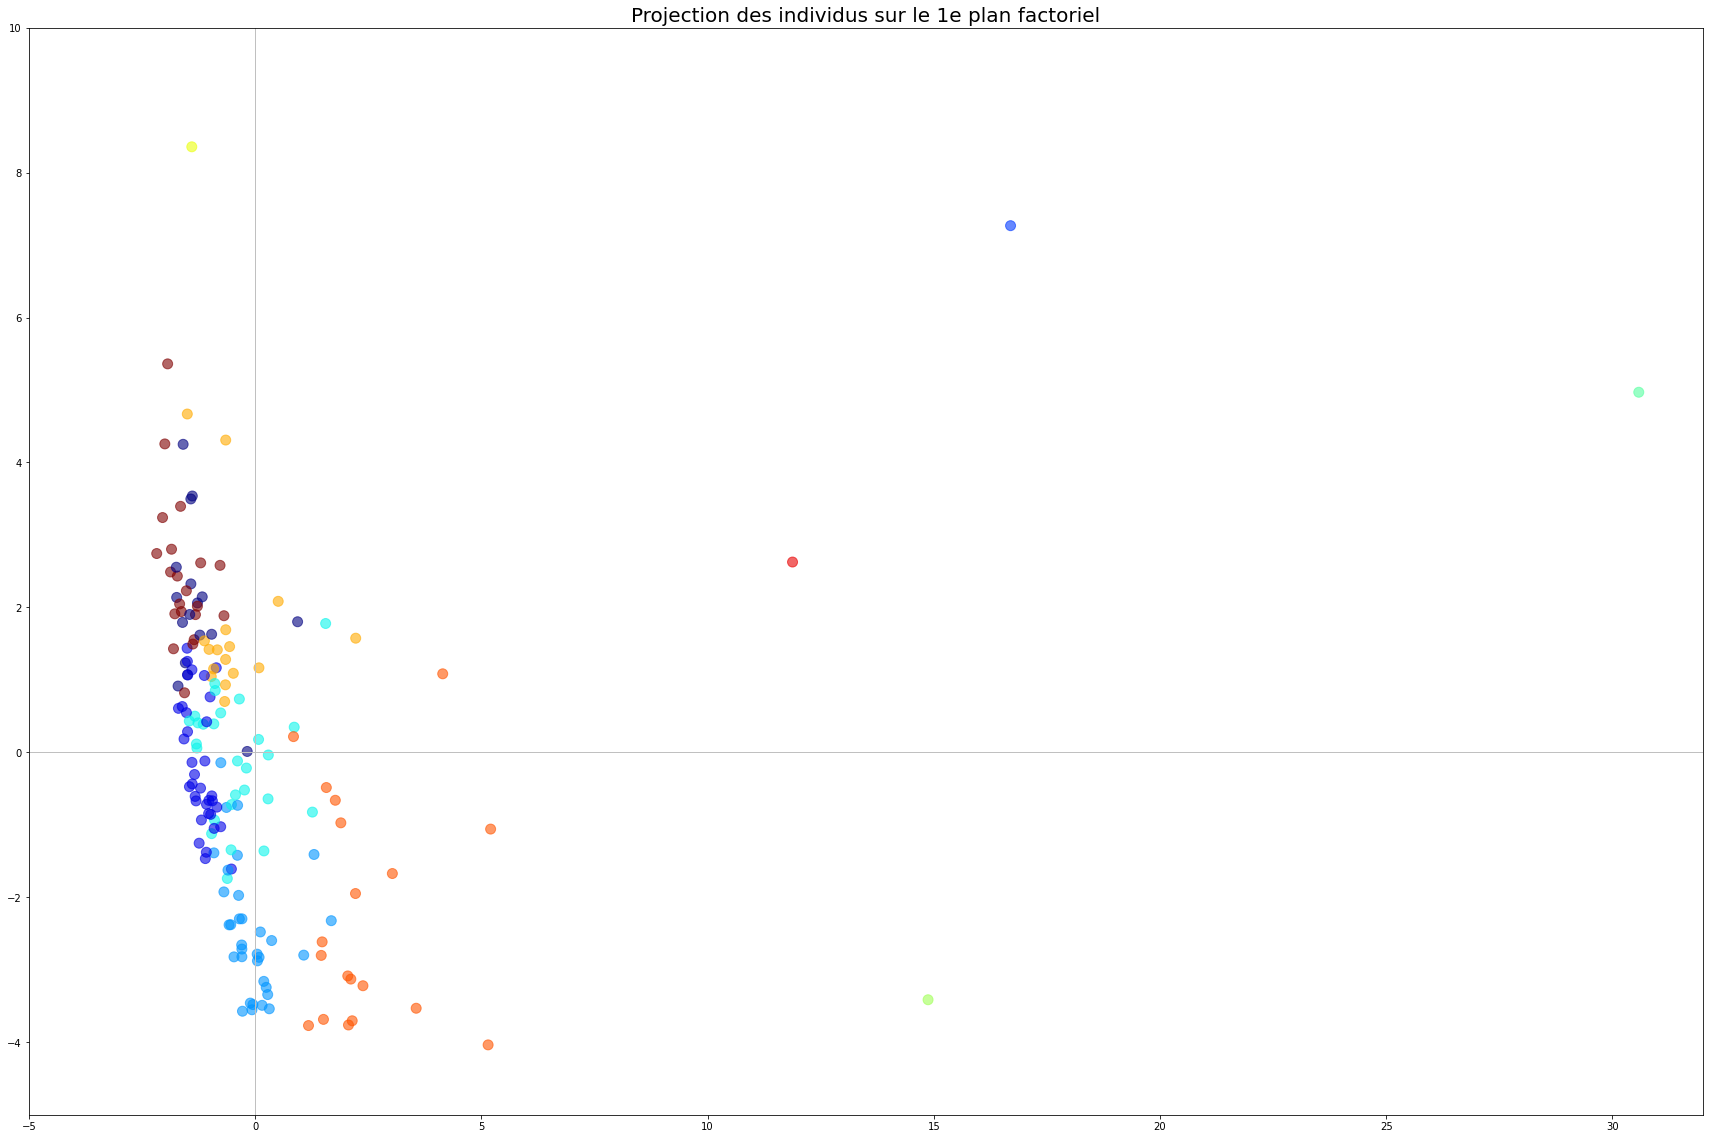

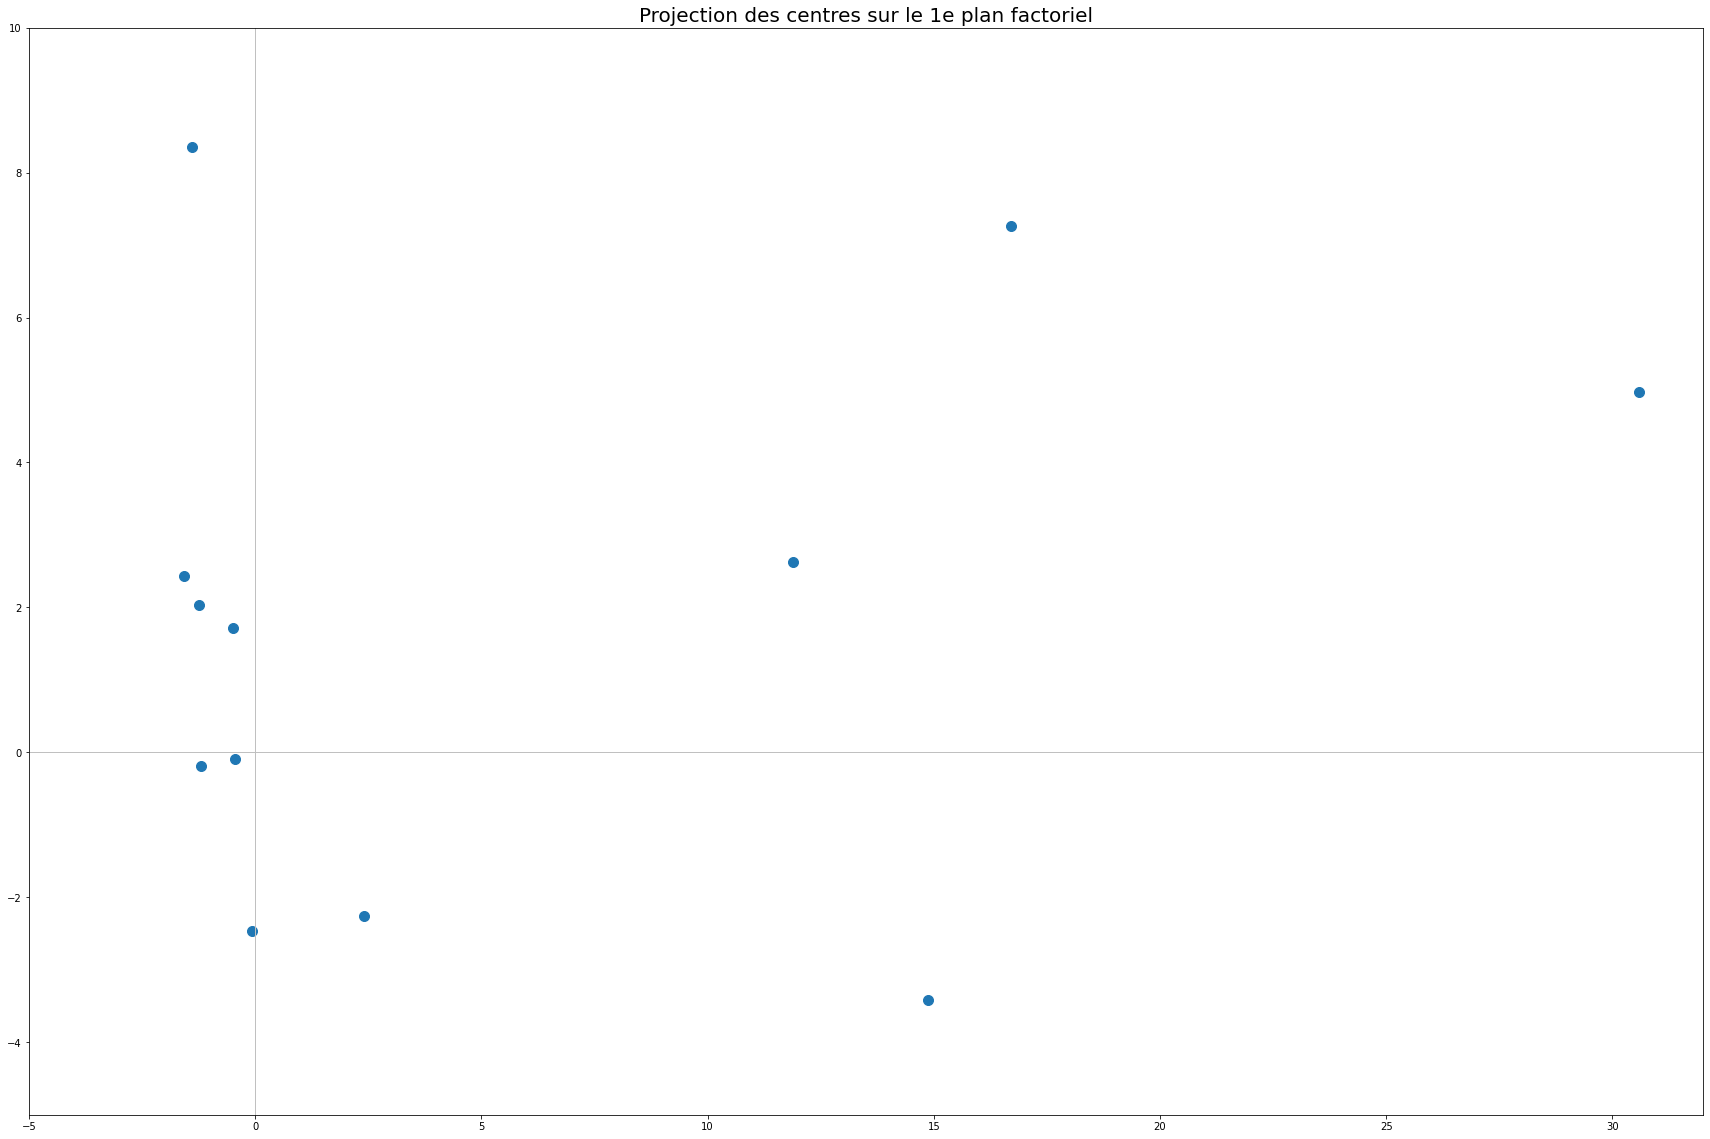

In [20]:
fig, axes = plt.subplots(figsize=(30,20))
axes.set_xlim(-5,32)
axes.set_ylim(-5,10)
plt.scatter(X_project[:, 0], X_project[:, 1], s=100, c=clusters.astype(float), cmap = 'jet', alpha=0.6)
plt.plot([-5,32],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-5,10],color='silver',linestyle='-',linewidth=1)
plt.title("Projection des individus sur le 1e plan factoriel", fontsize=20)
plt.savefig("P9_kmeans_1.png", dpi=300)
plt.show()


fig, axes = plt.subplots(figsize=(30,20))
axes.set_xlim(-5,32)
axes.set_ylim(-5,10)
centroids = km.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1], s=100)
plt.plot([-5,32],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-5,10],color='silver',linestyle='-',linewidth=1)
plt.title("Projection des centres sur le 1e plan factoriel", fontsize=20)
plt.savefig("P9_kmeans_centr_1.png", dpi=300)
plt.show()

### Réalisation du heatmap

In [21]:
# Création du df contenant les pays et le cluster associé
clust = pd.DataFrame({'id':names, 'values':clusters})

In [22]:
# Création du df permettant la réalisation de la heatmap
contr_ind = crt_ind_df.merge(clust, on="id")
contr_clust = contr_ind.groupby(["values"]).sum()
contr_ind.to_csv("P9_contrib_indivi_clust.csv")
contr_clust.to_csv("P9_contrib_clust.csv")

In [23]:
data_heat = contr_clust.rename(columns={"CTR_1":"Forte population et dispo ali", "CTR_2":"Croissance population et imports/exports", 
                                        "CTR_3":"Croissance imports/exports et PIB/RNB", "CTR_4":"Chômage et fortes exportations", 
                                        "CTR_5":"Peu de croissance PIB/RNB par rapport croissance pop et commerce extérieur", "CTR_6":"Croissance emploi", 
                                        "CTR_7":"Limitation commerce extérieur", "CTR_8":"Augmentation taux de mortalité", 
                                        "CTR_9":"Augmentation emploi, tourisme, limitation imports"})

data_heat = data_heat.rename(index={0:"cluster 1", 1:"cluster 2", 2:"cluster 3", 3:"cluster 4", 4:"cluster 5", 5:"cluster 6", 
                                    6:"cluster 7", 7:"cluster 8", 8:"cluster 9", 9:"cluster 10", 10:"cluster 11", 11:"cluster 12"})
data_heat

,Forte population et dispo ali,Croissance population et imports/exports,Croissance imports/exports et PIB/RNB,Chômage et fortes exportations,Peu de croissance PIB/RNB par rapport croissance pop et commerce extérieur,Croissance emploi,Limitation commerce extérieur,Augmentation taux de mortalité,"Augmentation emploi, tourisme, limitation imports"
values,,,,,,,,,
cluster 1,0.017359,0.099587,0.046998,0.066982,0.148339,0.078754,0.082403,0.153857,0.036239
cluster 2,0.027829,0.031021,0.073052,0.039211,0.119818,0.151924,0.076518,0.230798,0.061189
cluster 3,0.146304,0.060421,0.006100,0.045158,0.108667,0.000007,0.120748,0.001399,0.165634
cluster 4,0.005577,0.257811,0.134761,0.084895,0.105968,0.156727,0.054006,0.223426,0.059432
cluster 5,0.011211,0.020374,0.022146,0.088536,0.165506,0.181017,0.059344,0.123301,0.048777
cluster 6,0.490832,0.028248,0.001507,0.041170,0.000247,0.026527,0.009101,0.002536,0.066917
cluster 7,0.116092,0.013324,0.009200,0.008217,0.062447,0.000234,0.144558,0.004867,0.000143
cluster 8,0.001030,0.079869,0.311133,0.054838,0.114402,0.016649,0.011168,0.000559,0.007294
cluster 9,0.007846,0.076155,0.171103,0.035768,0.070621,0.175850,0.084124,0.051635,0.043080


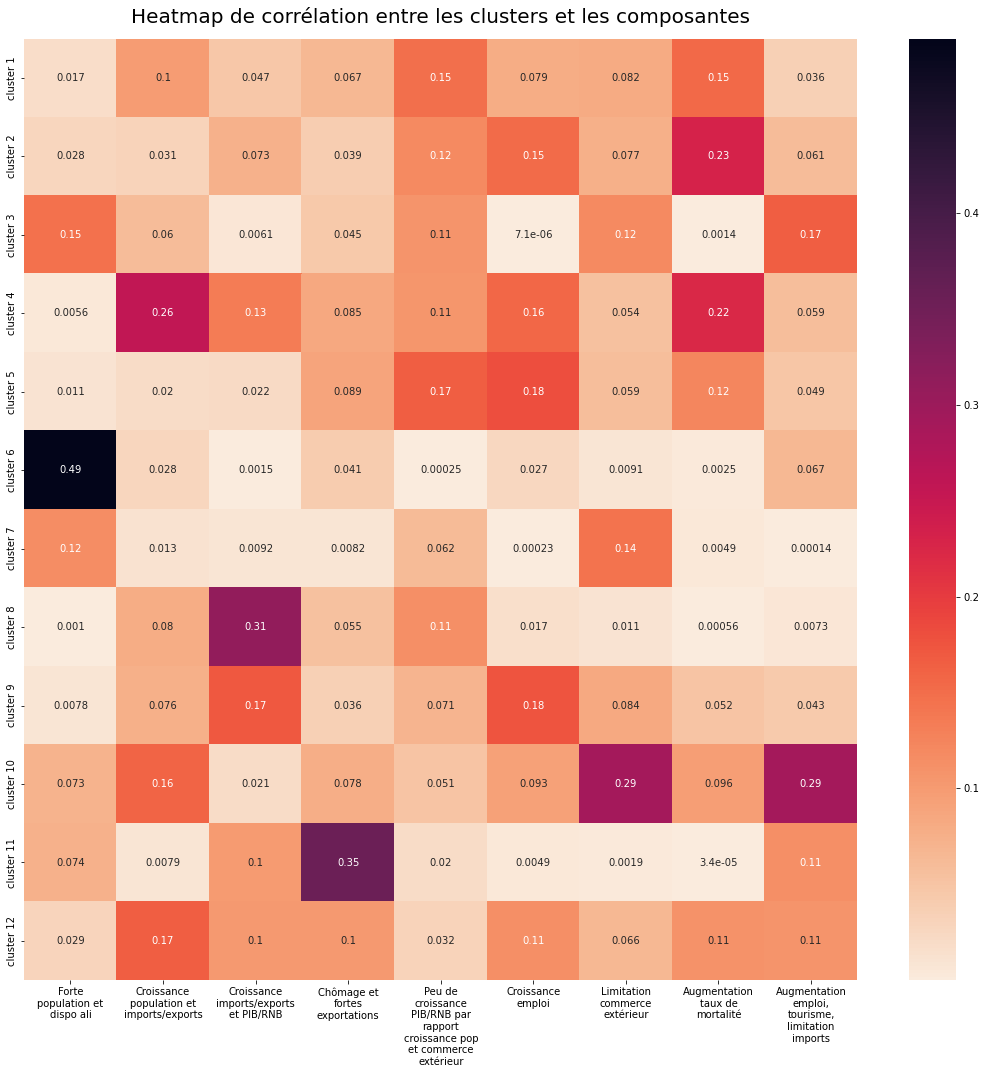

In [26]:
import textwrap


plt.figure(figsize=(15,15))
sns.heatmap(data_heat, cmap='rocket_r',  annot=True)
plt.title("Heatmap de corrélation entre les clusters et les composantes", y=1.01, fontsize=20)
plt.ylabel("")
labels=data_heat.columns.tolist()
labels=[textwrap.fill(text,15) for text in labels]
plt.xticks(np.arange(9)+0.5, labels, rotation=0)
plt.yticks(verticalalignment='center')
plt.tight_layout()
plt.savefig("P9_heatmap.png", dpi=300)
plt.show()